# Neural Network

## Data import

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import jax.numpy as jnp
import jax

from tqdm.notebook import tqdm
from math import sqrt
from random import seed
from random import randrange
from math import pi
from math import exp

In [37]:
# read data
data = pd.read_csv('creditcard.csv')

# convert data to numpy 2D array
data = data.to_numpy()
data.shape

(284807, 31)

## Data Division

Divide in training and test set 

In [38]:
# shuffle data
np.random.seed(0) # set seed to 0 for reproducibility
np.random.shuffle(data) 
fraction_validation = 0.3

# divide into training_set and test_set
num_train = int(data.shape[0] * (1 - fraction_validation))

train_set = data[:num_train,:]
valid_set = data[num_train:,:]

train_set.shape, valid_set.shape

((199364, 31), (85443, 31))

Divide the training set in subsets with specific ratios

In [39]:
fraud = train_set[train_set[:,-1] == 1]
non_fraud = train_set[train_set[:,-1] == 0]

np.random.seed(0) # set seed to 0 for reproducibility
np.random.shuffle(non_fraud) 

# ratio 50:50
new_non_fraud = non_fraud[:fraud.shape[0],:]

# concatenate the two matrix
train_set1 = np.r_[new_non_fraud,fraud]

np.random.seed(0) # set seed to 0 for reproducibility
np.random.shuffle(non_fraud) 

# ratio 34:64
new_non_fraud = non_fraud[:int(fraud.shape[0] * (66/34)),:]

# concatenate the two matrix
train_set2 = np.r_[new_non_fraud,fraud]

np.random.seed(0) # set seed to 0 for reproducibility
np.random.shuffle(non_fraud) 

# ratio 25:75
new_non_fraud = non_fraud[:int(fraud.shape[0] * (75/25)),:]

# concatenate the two matrix
train_set3 = np.r_[new_non_fraud,fraud]

train_set1.shape, train_set2.shape, train_set3.shape

((674, 31), (991, 31), (1348, 31))

Store the data in a matrix and the labels (0 - 1) in a vector

In [40]:
labels_train1 = train_set1[:,30]
x_data1 = train_set1[:,:30].transpose() 

labels_train1.shape, x_data1.shape

((674,), (30, 674))

In [41]:
labels_train2 = train_set2[:,30]
x_data2 = train_set2[:,:30].transpose() 

labels_train2.shape, x_data2.shape

((991,), (30, 991))

In [42]:
labels_train3 = train_set3[:,30]
x_data3 = train_set3[:,:30].transpose() 

labels_train3.shape, x_data3.shape

((1348,), (30, 1348))

In [43]:
labels_valid = valid_set[:,30]
x_data_valid = valid_set[:,:30].transpose() 

labels_valid.shape, x_data_valid.shape

((85443,), (30, 85443))

Create a [one-hot](https://en.wikipedia.org/wiki/One-hot) representation of the labels, that is a matrix where each row corresponds to a class (i.e. a digit).
the entries of the matrix are 1 if the sample corresponds to that digit, 0 otherwise

In [44]:
y_data1 = np.zeros((2, labels_train1.shape[0]))
for i in range(2):
  y_data1[i, labels_train1==i] = 1

In [45]:
y_data2 = np.zeros((2, labels_train2.shape[0]))
for i in range(2):
  y_data2[i, labels_train2==i] = 1

In [46]:
y_data3 = np.zeros((2, labels_train3.shape[0]))
for i in range(2):
  y_data3[i, labels_train3==i] = 1

In [47]:
y_data_valid = np.zeros((2, labels_valid.shape[0]))
for i in range(2):
  y_data_valid[i, labels_valid==i] = 1

Check that the matrix has exactly one element "1" in each column.

In [48]:
row_sums = np.sum(y_data1, axis = 0)
row_sums.min(), row_sums.max()

(1.0, 1.0)

In [73]:
y_data1.shape, y_data2.shape, y_data3.shape

((2, 674), (2, 991), (2, 1348))

## ANN training


The following function initialize the parameters (with Glorot Normal initialization) and a function implementing a feedforward ANN with tanh activation function.

To the last layer of the ANN, apply a *soft-max* layer. If $z_1, \dots, z_n$ are the activations of the last layer neurons, the soft-max layer produces $\hat{z}_1, \dots, \hat{z}_n$, defined as
$$
\hat{z}_i = \frac{e^{z_i}}{\sum_{j=1}^n e^{z_j}}
$$
In this manner the outputs of the ANN satisfy by construction:
- $\hat{z}_i \in [0,1]$
- $\sum_{j=1}^n \hat{z}_j = 1$

Therefore, they can be intepreted as probabilities.

When the ANN will be trained, we will take the digit corresponding the the hightest proabability as prediction of the model.

In [74]:
def initialize_params(layers_size):
  np.random.seed(0)
  params = list()
  for i in range(len(layers_size) - 1):
    params.append(np.random.randn(layers_size[i+1], layers_size[i]) * np.sqrt(2 / (layers_size[i] + layers_size[i+1])))
    params.append(np.zeros((layers_size[i+1],1)))
  return params

def ANN(x, params):
  W = params[0::2]
  b = params[1::2]
  layer = x 
  for i in range(len(W)):
    layer = W[i] @ layer - b[i]
    if i < len(W) - 1:
      layer = jnp.tanh(layer)
  layer_exp = jnp.exp(layer)
  return layer_exp / jnp.sum(layer_exp, axis = 0)

Test the ANN and check that the above properties are satisfied.

In [75]:
params = initialize_params([30, 20, 10, 5, 2])
y = ANN(x_data1, params)
y.shape
y.min(), y.max()
y_sum = jnp.sum(y, axis = 0)
y_sum.min(), y_sum.max()

(DeviceArray(1., dtype=float32), DeviceArray(1., dtype=float32))

In order to evaluete the algorithm we use the following metrics:
- mean square error
- cross entropy
- accuracy (fraction of samples correctly classified)

In [76]:
def MSE(x, y, params):
  return jnp.mean(jnp.square(y - ANN(x, params)))

def cross_entropy(x, y, params):
  y_appr = ANN(x, params)
  return - jnp.mean(jnp.sum(y*jnp.log(y_appr), axis=0))

def accuracy(x, y, params):
  digit_appr = jnp.argmax(ANN(x, params), axis = 0)
  digit      = jnp.argmax(y, axis = 0)
  return jnp.mean(digit == digit_appr) 

print('MSE:       %f' % MSE(x_data_valid, y_data_valid, params))
print('X entropy: %f' % cross_entropy(x_data_valid, y_data_valid, params))
print('accuracy:  %f' % accuracy(x_data_valid, y_data_valid, params))

MSE:       0.262866
X entropy: 0.718871
accuracy:  0.002118


The ANN-based classifier will be trained with three hidden layers with 20, 10, 5 neurons each.
Use 1000 epochs of the RMSProp algorithm, with decay rate 0.9 and $\delta = 10^{-7}$ and fixed learning rate $\lambda = 0.002$. Use minibatches with batch size of 400.

It is used the cross-entropy loss to drive the training.
To monitor training, store every 10 training epochs the following metrics in the following lists:
- `history_train_Xen`: cross-entropy (training set)
- `history_valid_Xen`: cross-entropy (validation set)
- `history_valid_MSE`: MSE (validation set)
- `history_valid_acc`: accuracy (validation set)

In [77]:
def training_loop(x_train,y_train):
  # Hyperparameters
  layers_size = [30, 20, 10, 5, 2]
  # Training options
  num_epochs = 500
  batch_size = 400
  learning_rate = 2e-3
  decay_rate = 0.9
  delta = 1e-7

  history_train_Xen = list()

  grad_jit = jax.jit(jax.grad(cross_entropy, argnums = 2))
  loss_Xen_jit = jax.jit(cross_entropy)

  params = initialize_params(layers_size)

  history_train_Xen.append(loss_Xen_jit(x_train, y_train, params))
  cumulate_grad = [0.0 for i in range(len(params))]

  t0 = time.time()
  for epoch in tqdm(range(num_epochs)):
    idxs = np.random.choice(x_train.shape[1], batch_size)
    g = grad_jit(x_train[:,idxs], y_train[:,idxs], params)
    for i in range(len(params)):
      cumulate_grad[i] = decay_rate*cumulate_grad[i] + (1 - decay_rate) * g[i]**2
      params[i] -= learning_rate / (delta + jnp.sqrt(cumulate_grad[i])) * g[i]
    history_train_Xen.append(loss_Xen_jit(x_train, y_train, params))

  print('train loss: %1.3e' % history_train_Xen[-1])
  plt.loglog(history_train_Xen, label = 'train loss')
  return params

## ANN test

  0%|          | 0/500 [00:00<?, ?it/s]

train loss: 6.933e-01


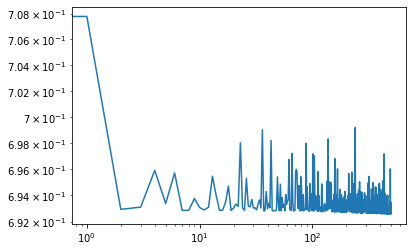

In [78]:
params1 = training_loop(x_data1,y_data1)

In [79]:
print('MSE:       %f' % MSE(x_data_valid, y_data_valid, params1))
print('X entropy: %f' % cross_entropy(x_data_valid, y_data_valid, params1))
print('Accurancy   ' + '{:.1%}'.format(accuracy(x_data_valid, y_data_valid, params1)))

MSE:       0.231346
X entropy: 0.655855
Accurancy   99.8%


  0%|          | 0/500 [00:00<?, ?it/s]

train loss: 6.430e-01


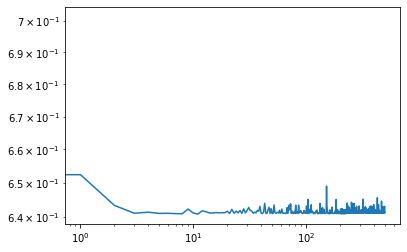

In [80]:
params2 = training_loop(x_data2,y_data2)

In [63]:
print('MSE:       %f' % MSE(x_data_valid, y_data_valid, params2))
print('X entropy: %f' % cross_entropy(x_data_valid, y_data_valid, params2))
print('Accurancy   ' + '{:.1%}'.format(accuracy(x_data_valid, y_data_valid, params2)))

MSE:       0.137695
X entropy: 0.463672
Accurancy   99.8%


  0%|          | 0/500 [00:00<?, ?it/s]

train loss: 5.616e-01


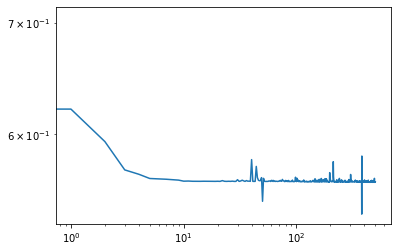

In [64]:
params3 = training_loop(x_data3,y_data3)

In [81]:
print('MSE:       %f' % MSE(x_data_valid, y_data_valid, params3))
print('X entropy: %f' % cross_entropy(x_data_valid, y_data_valid, params3))
print('Accurancy   ' + '{:.1%}'.format(accuracy(x_data_valid, y_data_valid, params3)))

MSE:       0.057610
X entropy: 0.273911
Accurancy   99.8%
